In [11]:
import re
import os
import numpy as np
import pandas as pd
import random
from tqdm import trange

from src.SNMF import SNMF, update_code_within_radius
from src.LMF import LMF
from src.SDL_SVP import SDL_SVP

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.decomposition import NMF
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import SparseCoder
from sklearn.metrics import roc_curve
from scipy.spatial import ConvexHull

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
sns.set_theme()
from matplotlib import rc
rc("text", usetex=False)

plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [12]:
def compute_accuracy_metrics(Y_test, P_pred, train_data=None, verbose=False):
    # y_test = binary label
    # P_pred = predicted probability for y_test
    # train_data = [X_train, ]
    # compuate various binary classification accuracy metrics
    # Compute classification statistics

    if train_data is not None:
        Y_train, P_train = train_data
        fpr, tpr, thresholds = metrics.roc_curve(Y_train, P_train, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc = round(metrics.auc(fpr, tpr), 4)
        print('threshold from training set used:', mythre)
    else:
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc_test = round(metrics.auc(fpr, tpr), 4)
        print('!!! test AUC:', myauc_test)

    threshold = round(mythre, 4)

    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = round( (tp + tn) / (tp + tn + fp + fn), 4)
    misclassification = 1 - accuracy
    sensitivity = round(tp / (tp + fn), 4)
    specificity = round(tn / (tn + fp), 4)
    precision = round(tp / (tp + fp), 4)
    recall = round(tp / (tp + fn), 4)
    fall_out = round(fp / (fp + tn), 4)
    miss_rate = round(fn / (fn + tp), 4)
    F_score = round(2 * precision * recall / ( precision + recall ), 4)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    #results_dict.update({'Fall_out': fall_out})
    #results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'F_score': F_score})


    if verbose:
        for key in [key for key in results_dict.keys() if key not in ['Y_test', 'Y_pred']]:
            print('% s ===> %.3f' % (key, results_dict.get(key)))
    return results_dict

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_topics=25, num_keywords_in_topic=5, save_name=None, grid_shape = [5,5]):
        # plot the class-conditioanl PMF as wordclouds 
        # W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
        # idx2words = list of words used in the vectorization of documents 
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        beta = W[1][0,1:num_topics+1] # first regression coefficient is for the constant term, so omit
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 12), subplot_kw={'xticks': [], 'yticks': []})
        idx_topic = np.argsort(beta)
        idx_topic = np.flip(idx_topic) 
        
        for ax, i in zip(axs.flat, np.arange(W[0].shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx_keyword = np.argsort(W[0][:,idx_topic[i]])
            idx_keyword = np.flip(idx_keyword)   
        
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx_keyword[j]])
                
            Y = " ".join(list_words)
            print('!! Y', Y)
            #stopwords = STOPWORDS
            wc = WordCloud(background_color="white",
#                           font_path='\Windows\Fonts\Verdana.ttf', 
                                  relative_scaling=0,
                                  width=400,
                                  height=400,
                                  #colormap='RdYlGn').generate(Y)
                                  colormap='Set2').generate(Y)
            
            ax.imshow(wc, interpolation="bilinear")
            #ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
            #                     interpolation="bilinear")
            
            ax.set_xlabel('%1.2f' % beta[idx_topic[i]], fontsize=15)
            ax.xaxis.set_label_coords(0.5, -0.05)
            
        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

In [13]:
path = "Data/fake_job_postings.csv"
data = pd.read_csv(path, delimiter=',')
Y = data['fraudulent']
print(sum(Y)/len(Y)) # prop : 5%

path = "Data/results_data_description2.csv"
text = pd.read_csv(path, delimiter = ',')

others = pd.read_csv("Data/fake_job_postings_v9.csv", delimiter=',')
covariate = others.get(others.keys()[1:73]) # covariates 

total_variable = list(covariate.keys()) + list(text.keys()) # variable name

#X = np.hstack((covariate, text))
print(Y.shape)

0.04843400447427293
(17880,)


In [14]:
Y = np.asarray(Y) # indicator of fraud postings
print('Y.shape', Y.shape)

text = text.values
text = text - np.min(text) # word frequency array
print('text.shape', text.shape) # words x docs

covariate = others.get(others.keys()[2])
covariate = covariate.values
covariate = covariate - np.min(covariate) 
print('covariate.shape', covariate.shape) 

Y.shape (17880,)
text.shape (17880, 2498)
covariate.shape (17880,)


In [16]:
np.random.seed(1)
Y_train, Y_test, text_train, text_test, covariate_train, covariate_test = train_test_split(Y, text, covariate, 
                                                                                           test_size = 0.2)
print('ratio of fraud postings in train set:', np.sum(Y_train)/Y_train.shape)
print('ratio of fraud postings in test set:', np.sum(Y_test)/Y_test.shape)

text_train, text_test = text_train.T, text_test.T
Y_train, Y_test = Y_train[np.newaxis,:], Y_test[np.newaxis,:]

if (len(covariate_train.shape) == 2):
    covariate_train, covariate_test = covariate_train.T, covariate_test.T
else:
    covariate_train, covariate_test = covariate_train[np.newaxis,:], covariate_test[np.newaxis,:]

#X0_train = np.vstack([covariate_train, text_train]) # for logistic
#X0_test = np.vstack([covariate_test, text_test])

X_train, X_test = text_train, text_test

print(Y_train.shape)
print(X_train.shape)
print(text_train.shape)
print(covariate_train.shape)

data = [X_train, X_test, Y_train, Y_test]
data_aux = [covariate_train, covariate_test]
if covariate_train is None:
    data_aux = None

ratio of fraud postings in train set: [0.0498462]
ratio of fraud postings in test set: [0.04278523]
(1, 14304)
(2498, 14304)
(2498, 14304)
(1, 14304)


In [21]:
os.getcwd()
#os.chdir("Output_files")
result_0 = np.load('results_SDL_sim8_fakejob.npy', allow_pickle=True) # dict = 10

In [36]:
W0 = result_0[7].get('loading')
H0 = result_0[7].get('code')
#W0 = [W0[0], W0[1][0,1:][np.newaxis,:]]
H0.shape

(10, 14304)

In [35]:
X_train, X_test, Y_train, Y_test = data
if data_aux is not None:
    covariate_train, covariate_test = data_aux

r = 10
beta = 0.5
iteration = 30

p = X_train.shape[0]
results_dict_list = []
full_result_list = []


SNMF_class_new = SNMF(X=[X_train, Y_train],  # data, label
                                    X_test=[X_test, Y_test],
                                    X_auxiliary = covariate_train,
                                    X_test_aux = covariate_test,
                                    n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                    ini_loading=W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                    # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                    ini_code = H0,
                                    xi=xi,  # weight on label reconstruction error
                                    L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                    L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                    nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                                    full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression


results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                        beta = beta,
                                        search_radius_const=iteration*np.linalg.norm(X_train),
                                        update_nuance_param=False,
                                        if_compute_recons_error=True, if_validate=False)

results_dict_new.update({'method': 'SDL-filt'})
results_dict_new.update({'beta': beta})
results_dict_new.update({'time_error': results_dict_new.get('time_error')})


  0%|          | 0/30 [00:00<?, ?it/s]

initial loading beta [[-1.50985154e+01 -4.81036626e-01  5.63091886e-04 -8.00035653e-01
   2.13308115e+01 -1.13876304e+00 -1.12732568e+00  1.84889286e-01
  -4.45503753e-01 -7.37289692e-01]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12 is different from 10)

# Without covariate

threshold from training set used: 0.07943784912700198
AUC ===> 0.965
Opt_threshold ===> 0.079
Accuracy ===> 0.913
Sensitivity ===> 0.784
Specificity ===> 0.919
Precision ===> 0.301
F_score ===> 0.436
                word      coef
1433           money  3.320977
707             earn  3.314975
1299            link  3.170778
761      engineering  3.002885
2072           skill  2.609279
780            entry  2.498290
126           answer  2.468726
971              gas  2.372947
57    administrative  2.251751
181        assistant  2.224851
2438             web -1.661945
1361       marketing -1.761287
1950            role -1.785119
1014            grow -1.805286
235             base -1.984187
1942           right -2.084742
2370            user -2.143061
2440         website -2.223821
387           client -2.521187
2240            team -2.650815


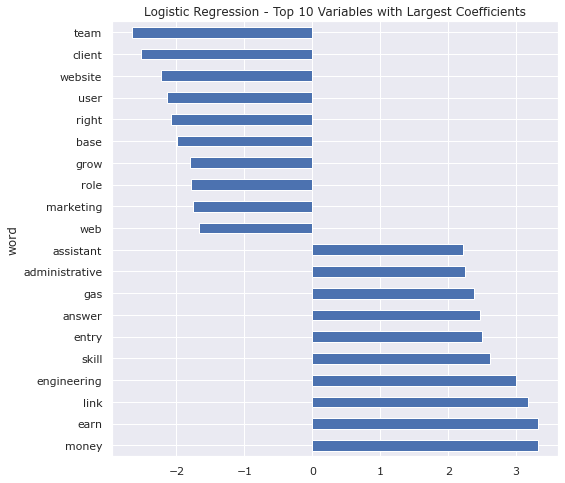

In [21]:
###### LR ######

results_dict_list = []

clf = LogisticRegression(random_state=0).fit(text_train.T, Y_train[0,:])
P_train = clf.predict_proba(text_train.T)
P_pred = clf.predict_proba(text_test.T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)

results.update({'method': 'LR'})
results.update({'xi': None})
results.update({'beta': None})
results.update({'Relative_reconstruction_loss (test)': 1})
results.update({'Accuracy': results.get('Accuracy')})
results_dict_list.append(results.copy())

mybeta = clf.coef_
result = pd.DataFrame({"word" : total_variable[72:], "coef": mybeta[0]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

plt.rcParams['font.sans-serif'] = ['Verdana']

fig, ax = plt.subplots(1,1,figsize=(8,8))
result.plot.barh(ax = ax, x = 'word', y = 'coef', legend = None)
ax.set_title("Logistic Regression - Top 10 Variables with Largest Coefficients")
plt.show()
#plt.savefig("Output_files/Logistic/bargraph of top 10 beta coefficients - " + covariate + "_" + str(i) + ".pdf", bbox_inches='tight')

100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


threshold from training set used: 0.05484719777066024
AUC ===> 0.825
Opt_threshold ===> 0.055
Accuracy ===> 0.732
Sensitivity ===> 0.758
Specificity ===> 0.731
Precision ===> 0.112
F_score ===> 0.195
!! Y shall community week marketing patient content event program fail member
!! Y customer service beauty fragrance product retail able email luxury need
!! Y service customer position client entry employee time work level representative
!! Y project client management team manage manager business process development resource
!! Y user help designer digital web design team creative brand look
!! Y sale account client business new prospect lead relationship opportunity representative
!! Y contract month today airfare furnish private url apply love want
!! Y mail file customer high cooperative perform continued satisfy integral log
!! Y career admin nvq kept role work permanent fantastic start old
!! Y url kid loan asium usd living housing student reimbursedexcellent credit
!! Y website sear

IndexError: index 24 is out of bounds for axis 0 with size 24

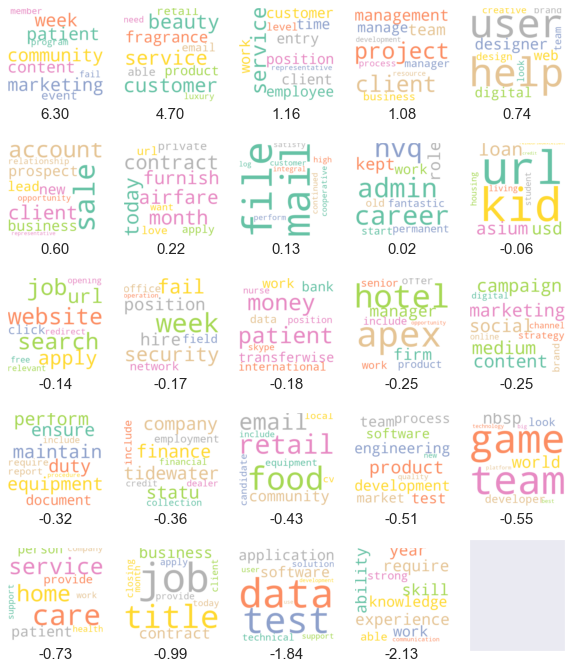

In [9]:
# MF -> LR

r = 25
iteration = 200

W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = W.T @ text_train
new_test = W.T @ text_test

clf = LogisticRegression(random_state=0).fit(new_train.T, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train.T) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test.T) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
#results_dict_list.append(results.copy())

W0 = [W, clf.coef_]
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

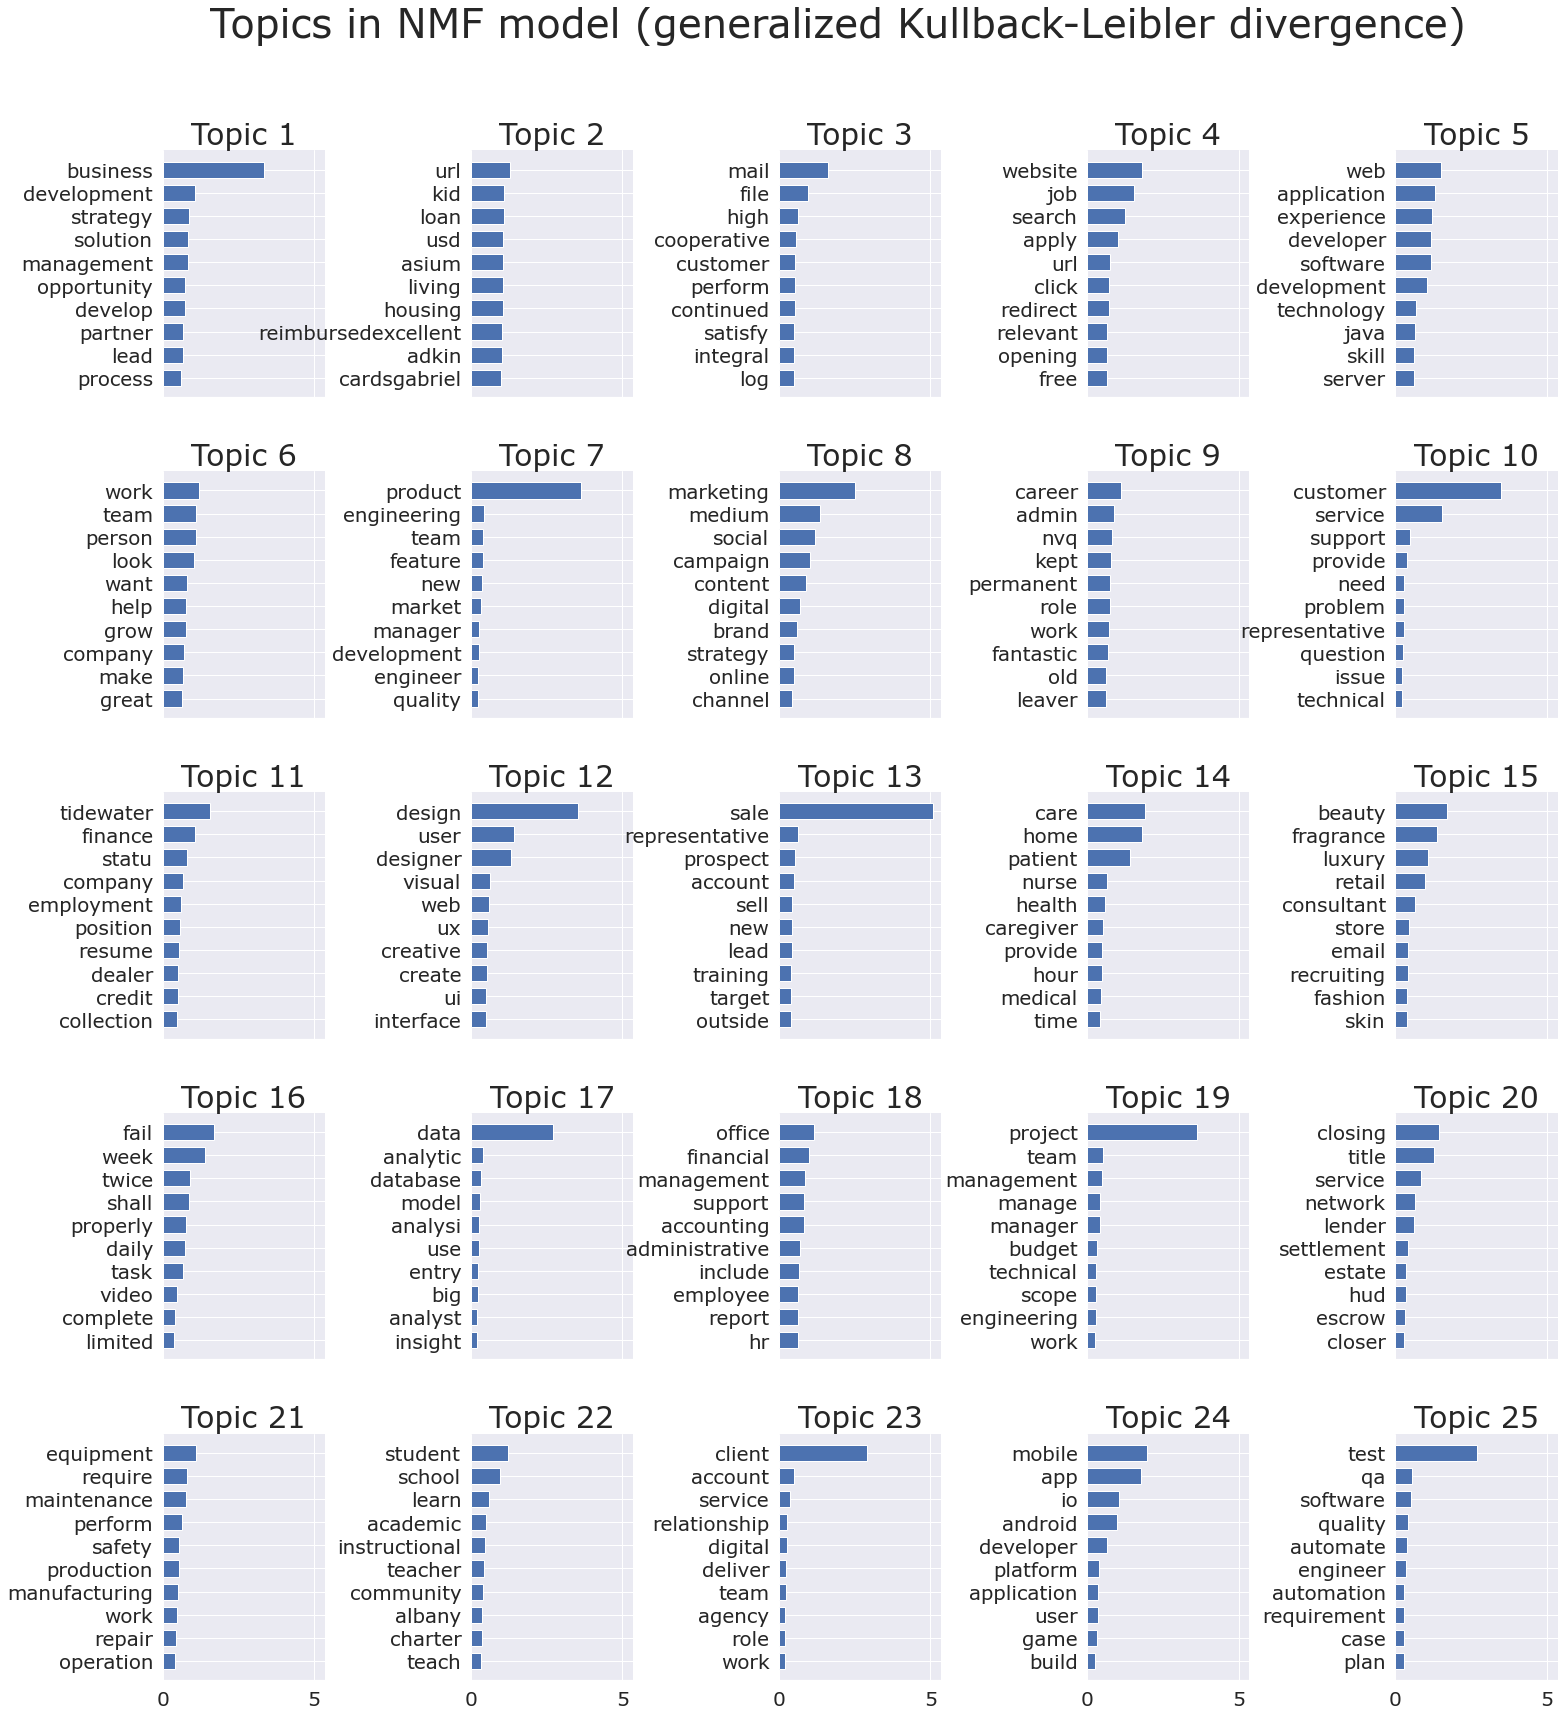

In [37]:
from sklearn.decomposition import NMF

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


nmf = NMF(n_components=25, random_state=1).fit(text_train.T)
plot_top_words(
    nmf,
    total_variable[72:],
    10,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)    

In [10]:
# SDL - filter_based

xi_list = [0.1]
iter_avg = 1
beta = 0.5

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)
        results_dict_new.update({'method': 'SDL-filt'})
        results_dict_new.update({'beta': beta})
        #results_dict_list.append(results_dict_new.copy())
        # print('Beta_learned', results_dict.get('loading')[1])


  0%|          | 0/200 [00:00<?, ?it/s]

initial loading beta [[ 0.50907666 -0.55433813  0.74813172  0.84107089  0.25572343  0.64567973
   0.74686666  0.76829886 -0.02087107  0.78029015 -0.09034811  0.40566519
   0.66940331 -0.51974541  0.20188274 -0.4631894  -0.08895006 -0.25596145
   0.65028637  0.03700831 -0.03477473 -0.75201717  0.79781533  0.46428908
  -0.93400226  0.27858027]]


100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


# With Covariate

In [6]:
###### LR ######

results_dict_list = []

clf = LogisticRegression(random_state=0).fit(X_train.T, Y_train[0,:])
P_train = clf.predict_proba(X_train.T)
P_pred = clf.predict_proba(X_test.T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)

results.update({'method': 'LR'})
results.update({'xi': None})
results.update({'beta': None})
results.update({'Relative_reconstruction_loss (test)': 1})
results.update({'Accuracy': results.get('Accuracy')})
results_dict_list.append(results.copy())

mybeta = clf.coef_
result = pd.DataFrame({"word" : total_variable, "coef": mybeta[0]})
result1 = result.sort_values(by = 'coef', ascending = False).head(20)
result0 = result.sort_values(by = 'coef', ascending = False).tail(20)
result = pd.concat([result1, result0])
result

plt.rcParams['font.sans-serif'] = ['Verdana']

fig, ax = plt.subplots(1,1,figsize=(8,8))
result.plot.barh(ax = ax, x = 'word', y = 'coef', legend = None)
ax.set_title("Logistic Regression - Top 10 Variables with Largest Coefficients")
plt.show()
#plt.savefig("Output_files/Logistic/bargraph of top 10 beta coefficients - " + covariate + "_" + str(i) + ".pdf", bbox_inches='tight')

threshold from training set used: 0.11265808892075124
AUC ===> 0.976
Opt_threshold ===> 0.113
Accuracy ===> 0.942
Sensitivity ===> 0.778
Specificity ===> 0.950
Precision ===> 0.407
F_score ===> 0.535


C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# MF -> LR
r = 25
iteration = 200

W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = np.vstack((covariate_train, W.T @ text_train)).T
new_test = np.vstack((covariate_test, W.T @ text_test)).T

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:41<00:00,  2.31s/it]
C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


threshold from training set used: 0.051023143233831426
AUC ===> 0.907
Opt_threshold ===> 0.051
Accuracy ===> 0.818
Sensitivity ===> 0.810
Specificity ===> 0.818
Precision ===> 0.166
F_score ===> 0.276


In [ ]:
# MF -> LR
W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = np.vstack((covariate_train, W.T @ text_train)).T
new_test = np.vstack((covariate_test, W.T @ text_test)).T

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

W0 = [W, clf.coef_]
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [128]:
### NMF
print("nmf -> LR")
nmf = NMF(n_components = 25, random_state=1, alpha=0, l1_ratio=0).fit(text_train.T)
W = nmf.components_
H_train = nmf.fit_transform(text_train.T)
H_test = nmf.fit_transform(text_test.T, W = W)        

new_train = np.hstack((covariate_train.T, H_train))
new_test = np.hstack((covariate_test.T, H_test))

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

threshold from training set used: 0.047842206028086816
AUC ===> 0.884
Opt_threshold ===> 0.048
Accuracy ===> 0.770
Sensitivity ===> 0.745
Specificity ===> 0.771
Precision ===> 0.127
F_score ===> 0.217


C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [136]:
mybeta = clf.coef_
dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": mybeta[0][1:26]})
result
#idx2word = data.keys()
#fig_path = "Output_files/NMF/Wordcloud - " + covariate + "_" + str(i) + ".pdf"

plot_topic_wordcloud_nmf(result, W, total_variable[72:], num_topics=25, 
                         num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

word      coef
0    Topic1 -2.265651
1    Topic2 -0.202300
2    Topic3  0.393679
3    Topic4 -0.832529
4    Topic5  0.436534
5    Topic6 -0.280365
6    Topic7 -0.150995
7    Topic8  0.419902
8    Topic9  0.652758
9   Topic10  0.455621
10  Topic11 -1.099237
11  Topic12 -0.652917
12  Topic13  0.281917
13  Topic14 -0.078193
14  Topic15  0.152144
15  Topic16 -0.256898
16  Topic17 -0.016351
17  Topic18  0.498495
18  Topic19  0.069487
19  Topic20 -0.410768
20  Topic21 -0.800343
21  Topic22  1.341403
22  Topic23 -0.053682
23  Topic24  0.405450
24  Topic25  0.636080

In [43]:
iteration = 50
beta_list = [0.5]

for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            SNMF_class_new = SNMF(X=[text_train, Y_train],  # data, label
                            X_test=[text_test, Y_test],
                            X_auxiliary = covariate_train,
                            X_test_aux = covariate_test,      
                            n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                            # ini_loading=None,  # Initialization for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            # ini_code = H_true,
                            xi=xi,  # weight on label reconstruction error
                            L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                            L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                            nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                            full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

            results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                    beta = beta,
                                                    search_radius_const=np.linalg.norm(X_train),
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)
            results_dict_new.update({'method': 'SDL-filt'})
            results_dict_new.update({'beta': beta})
            results_dict_list.append(results_dict_new.copy())
            # print('Beta_learned', results_dict.get('loading')[1])

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

initial loading beta [[-0.37033872  0.26128626  0.52188425 -0.4827226   0.14629107 -0.22830654
   0.68590584 -0.20734934  0.17542868  0.49938051  0.30030775  0.22007475
   0.65142762 -0.15039218 -0.80344429  0.20172949 -0.59530628  0.00876019
  -0.76376856  0.19353964 -0.82269005 -0.09863528  0.30783503 -0.69200087
   0.32586468 -0.45791118 -0.13824263  0.69675715 -0.85956675 -0.31697959
  -0.06685688  0.03209329  0.49757284  0.67407114  0.40065264  0.90154891
  -0.01599784  0.75584127  0.48277698 -0.56093192 -0.87306821 -0.95450237
  -0.07354556  0.49764927  0.07878207 -0.32766757  0.29333808  0.60657511
  -0.87118853  0.28214659 -0.34534121 -0.24119111 -0.91639839  0.01276432
  -0.89077575  0.15016636 -0.78757113  0.07248299  0.9750016   0.21922166
  -0.28625005 -0.01469196  0.61054144  0.3371962   0.59362429  0.49520596
  -0.62356571 -0.25967926 -0.27929525 -0.91961893  0.86793966  0.47052964
  -0.53718709  0.64126926 -0.30591099 -0.39834925  0.92806885  0.88902533
  -0.97586678  0.

C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  2%|█▋                                                                                 | 1/50 [00:05<04:48,  5.88s/it]C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to th

 26%|█████████████████████▎                                                            | 13/50 [01:08<03:15,  5.29s/it]


KeyboardInterrupt: 

In [9]:
# SDL_SVP_filter

xi_list = [1]
iter_avg = 1
data_scale = 1
iteration = 200
r = 25

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SDL_SVP_class = SDL_SVP(X=[text_train/data_scale, Y_train],  # data, label
                                X_test=[text_test/data_scale, Y_test],
                                X_auxiliary = covariate_train/data_scale,
                                X_test_aux = covariate_test/data_scale,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SDL_SVP_class.fit(iter=iteration, subsample_size=None,
                                                beta = 0,
                                                nu = 2,
                                                search_radius_const=0.05,
                                                update_nuance_param=False,
                                                SDL_option = 'filter',
                                                prediction_method_list = ['filter'],
                                                fine_tune_beta = False,
                                                if_compute_recons_error=True, if_validate=False)
        results_dict_new.update({'method': 'SDL-conv-filt'})
        results_dict_new.update({'beta': None})
        results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (filter)')})
        results_dict_new.update({'F_score': results_dict_new.get('F_score (filter)')})
        #results_dict_list.append(results_dict_new.copy())

initial loading beta [[ 0.23710111  0.62758328  0.66245971  0.42208135  0.43851592  0.22699539
   0.09709088 -0.74607475 -0.12121057  0.41334795 -0.31716823  0.08219977
  -0.73968615 -0.09765306  0.19870961 -0.60674619 -0.17109857  0.28469404
   0.70534252  0.40901206 -0.02437271  0.63057346 -0.92338172 -0.23964049
   0.38338149 -0.39075694  0.61487131 -0.4882114  -0.92456247  0.78852112
  -0.19828062 -0.13397632 -0.85983204 -0.95224405 -0.19780317 -0.04185715
  -0.91733648  0.04616429  0.87496376  0.81292524 -0.10597802 -0.92449811
   0.3506999  -0.77782398 -0.27693391  0.37951275 -0.84618811 -0.6736478
  -0.60482165 -0.89630582  0.99934029 -0.67562225  0.67605583 -0.24093191
  -0.09064493  0.36407943  0.72895112 -0.92155471  0.19980773  0.30988788
  -0.2393577  -0.43977991  0.0090301   0.82557208  0.96614885 -0.99854286
  -0.99745286  0.70477899 -0.67586909 -0.26061713 -0.49211209  0.93288838
   0.07143348  0.94931509  0.27467773  0.68249303  0.14474529 -0.46602528
  -0.1177298  -0.5

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

*** rel_error_data train 81818.65998101988
~~~ rel_error_data train 0.9855336495113912
--- Training --- [threshold, AUC] =  [1.0, 0.5]
--- Iteration 0: Training loss --- [Data, Label, Total] = [1165352205.577950.3, 1225987.747025.3, 1166578193.324975.3]


C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:319: RuntimeWarning: overflow encountered in exp
  P_pred = np.matmul(W[1], X0_ext)
C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
  0%|▍                                                                             | 1/200 [07:53<26:09:22, 473.18s/it]C:\Users\ljw95\OneDrive\PycharmProjects\LMF\src\SDL_SVP.py:141: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  1%|▊                                                                             | 2/200 [13:31<22:18:20, 405.56s/it]


KeyboardInterrupt: 

In [58]:
H_ext = np.vstack((np.ones(text_test.shape[1]), H))
X0_ext = np.vstack((H_ext, covariate_test))
p_pred = np.matmul(W[1],X0_ext)
p_pred.shape

(1, 3576)

In [54]:
W[1].shape

(1, 98)

'/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF'

In [5]:
os.chdir("Output_files/SDL_sim7")
result_0 = np.load('results_SDL_sim7_fakejob.npy', allow_pickle=True)

In [6]:
method_0 = ["LR", "MF-LR", "SDL-filt", "SDL-feat (naive)", "SDL-conv-filt", "SDL-conv-feat (naive)"]
#xi_0 = [0, 0.1, 1, 5, 10]

method_0 = []
xi_0 = []
accuracy_0 = []
sensitivity_0 = []
specificity_0 = []
f_score_0 = []
reconstruct_0 = []

for idx in range(len(result_0)):
    
    if (result_0[idx].get('method') == "LR"):     
        method_0.append("Logistic Regression (LR)")
        xi_0.append(str("---"))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))     

for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "MF-LR"):     
        method_0.append("NMF - LR")
        xi_0.append(str("---"))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))     


for idx in range(len(result_0)):
        
    if (result_0[idx].get('method') == "SDL-filt"): 
        method_0.append("SDL - Filter")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))       


for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "SDL-feat (naive)"):     
        method_0.append("SDL - Feature")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (naive)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (naive)'))
        specificity_0.append(result_0[idx].get('Specificity (naive)'))
        f_score_0.append(result_0[idx].get('F_score (naive)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))

for idx in range(len(result_0)):
        
    if (result_0[idx].get('method') == "SDL-conv-filt"):
        method_0.append("SDL - Filter (Convex)")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (filter)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (filter)'))
        specificity_0.append(result_0[idx].get('Specificity (filter)'))
        f_score_0.append(result_0[idx].get('F_score (filter)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))

for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "SDL-conv-feat (naive)"):     
        method_0.append("SDL - Feature (Convex)")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (naive)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (naive)'))
        specificity_0.append(result_0[idx].get('Specificity (naive)'))
        f_score_0.append(result_0[idx].get('F_score (naive)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))
 

In [106]:
#C:\Windows\Fonts
#os.chdir("Windows/Fonts/Verdana.ttf")
#os.getcwd()

'C:\\Windows\\Fonts'

In [7]:
def plot_topic_wordcloud(W, idx2word, num_topics=25, num_keywords_in_topic=5, save_name=None, grid_shape = [5,5]):
        # plot the class-conditioanl PMF as wordclouds 
        # W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
        # idx2words = list of words used in the vectorization of documents 
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        beta = W[1][0,1:num_topics+1] # first regression coefficient is for the constant term, so omit
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 12), subplot_kw={'xticks': [], 'yticks': []})
        idx_topic = np.argsort(beta)
        idx_topic = np.flip(idx_topic) 
        
        for ax, i in zip(axs.flat, np.arange(W[0].shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx_keyword = np.argsort(W[0][:,idx_topic[i]])
            idx_keyword = np.flip(idx_keyword)   
        
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx_keyword[j]])
                
            Y = " ".join(list_words)
            print('!! Y', Y)
            #stopwords = STOPWORDS
            wc = WordCloud(background_color="white",
#                           font_path='\Windows\Fonts\Verdana.ttf', 
                                  relative_scaling=0,
                                  width=400,
                                  height=400,
                                  #colormap='RdYlGn').generate(Y)
                                  colormap='Set2').generate(Y)
            
            ax.imshow(wc, interpolation="bilinear")
            #ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
            #                     interpolation="bilinear")
            
            ax.set_xlabel('%1.2f' % beta[idx_topic[i]], fontsize=15)
            ax.xaxis.set_label_coords(0.5, -0.05)
            
        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')


!! Y work look start skill time mso learn person want company
!! Y client home data work time caregiver day person entry team
!! Y team test work software product person grow customer new look
!! Y customer service support require provide equipment include duty quality maintain
!! Y project development technical test software application experience requirement management engineering
!! Y team work experience software look developer environment join want skill
!! Y management accounting operation process financial hr office business maintain ensure
!! Y new intern use base help program high look excellent online
!! Y company tidewater finance position opportunity work employee time benefit hour
!! Y career admin kept nvq permanent start school work old fantastic
!! Y beauty fragrance retail luxury consultant store recruiting make fashion want
!! Y test campaign real engineer hotel software company work product manager
!! Y fail week twice shall properly daily task experience data securi

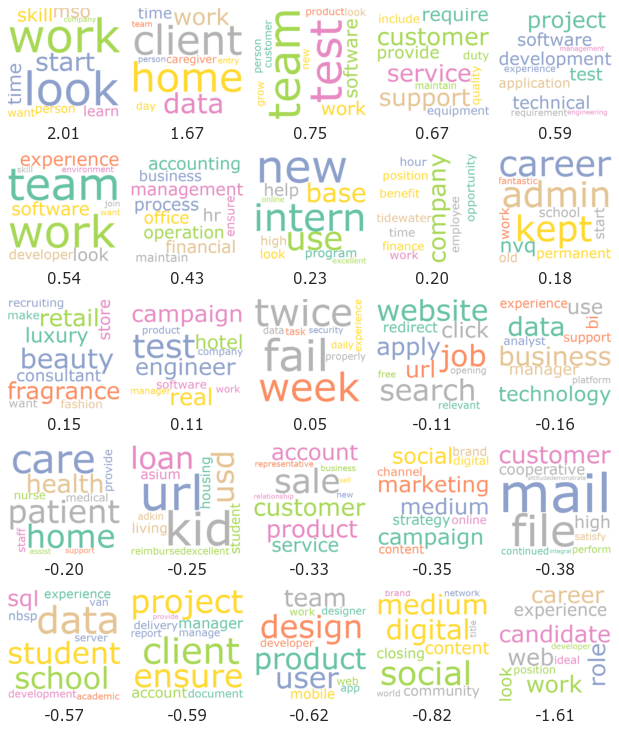

In [116]:
# MF -> LR
W = result_0[1].get('W')
W2 = result_0[1].get('beta_regression')
W2 = np.asarray([list([1]) + list(W2[0])])
plot_topic_wordcloud([W,W2], total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y contract month today airfare furnish private url apply love want
!! Y service customer position client entry employee time work level representative
!! Y experience skill year require ability knowledge work strong able communication
!! Y week security fail position hire network shall field office operation
!! Y maintain equipment perform duty ensure document require report include procedure
!! Y product development engineering team test process software market quality new
!! Y patient money transferwise work bank international data position skype nurse
!! Y project client management team manage manager business process development resource
!! Y shall community week marketing patient content event program fail member
!! Y data test application software technical solution support user development use
!! Y game team nbsp world developer look technology big platform best
!! Y apex hotel manager firm product include offer senior work opportunity
!! Y care service home patient person pr

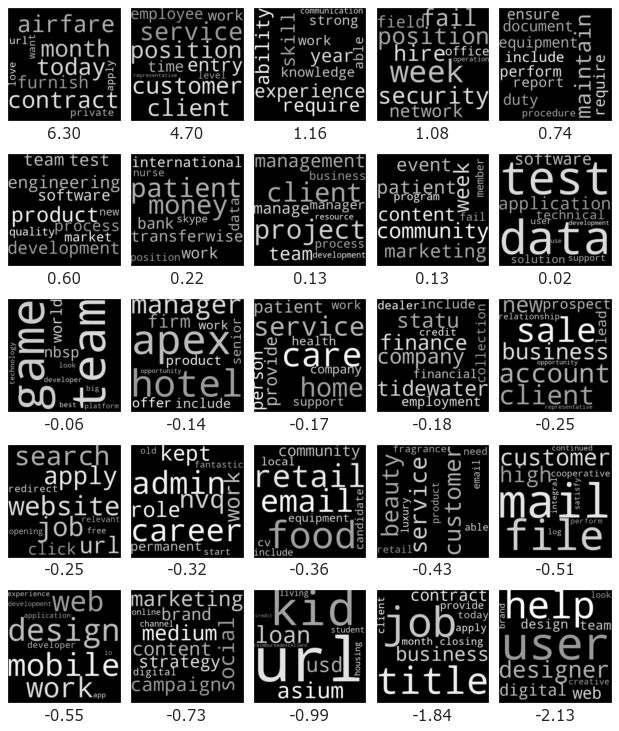

In [68]:
# MF -> LR
W = result_0[2].get('W')
W2 = result_0[2].get('beta_regression')
W2 = np.asarray([list([1]) + list(W2[0])])
plot_topic_wordcloud([W,W2], total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [74]:
for i in range(3,13): 
    print(i, result_0[i].get('method'), result_0[i].get('xi'), result_0[i].get('F_score'))

3 SDL-filt 0.01 0.45875251509054327
4 SDL-filt 0.01 0.36245954692556637
5 SDL-filt 0.1 0.46540880503144655
6 SDL-filt 0.1 0.46249999999999997
7 SDL-filt 1 0.39929328621908133
8 SDL-filt 1 0.4043715846994535
9 SDL-filt 5 0.3785714285714285
10 SDL-filt 5 0.3586429725363489
11 SDL-filt 10 0.3511705685618729
12 SDL-filt 10 0.37837837837837834


!! Y earn money engineering entry link skill administrative gas answer oil
!! Y earn money engineering entry link skill administrative gas answer time
!! Y earn money engineering entry link skill administrative gas answer time
!! Y earn money engineering entry link skill administrative answer gas time
!! Y work customer service project experience product job company position provide
!! Y sale customer business client product account service team management marketing
!! Y url kid loan usd asium living housing student reimbursedexcellent adkin
!! Y mail file customer care high cooperative continued site integral log
!! Y team design client marketing web product user developer new development
!! Y team client marketing design web user new developer development grow
!! Y team client website user right base care marketing role growth
!! Y team client marketing user website web grow role base developer
!! Y client team sale marketing website role grow base user web
!! Y website team client u

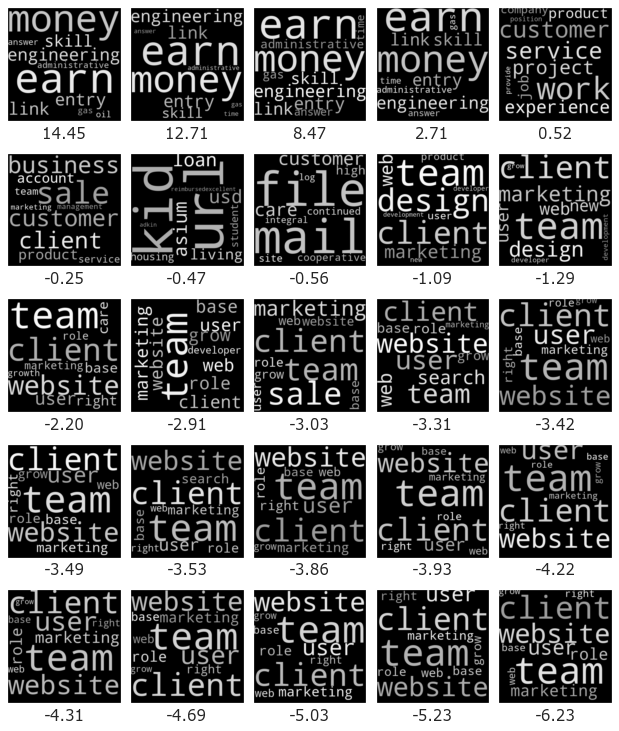

In [77]:
###### Filter-based (xi = 0.1)
W = result_0[5].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [67]:
for i in range(len(result_0)):
    print(i, result_0[i].get('method'))

0 LR
1 MF-LR
2 MF-LR
3 SDL-filt
4 SDL-filt
5 SDL-filt
6 SDL-filt
7 SDL-filt
8 SDL-filt
9 SDL-filt
10 SDL-filt
11 SDL-filt
12 SDL-filt
13 SDL-feat (naive)
14 SDL-feat (naive)
15 SDL-feat (naive)
16 SDL-feat (naive)
17 SDL-feat (naive)
18 SDL-feat (naive)
19 SDL-feat (naive)
20 SDL-feat (naive)
21 SDL-feat (naive)
22 SDL-feat (naive)
23 SDL-conv-filt
24 SDL-conv-filt
25 SDL-conv-filt
26 SDL-conv-filt
27 SDL-conv-filt
28 SDL-conv-filt
29 SDL-conv-filt
30 SDL-conv-filt
31 SDL-conv-filt
32 SDL-conv-filt
33 SDL-conv-feat (naive)
34 SDL-conv-feat (naive)
35 SDL-conv-feat (naive)
36 SDL-conv-feat (naive)
37 SDL-conv-feat (naive)
38 SDL-conv-feat (naive)
39 SDL-conv-feat (naive)
40 SDL-conv-feat (naive)
41 SDL-conv-feat (naive)
42 SDL-conv-feat (naive)


In [78]:
for i in range(13,23): 
    print(i, result_0[i].get('method'), result_0[i].get('xi'), result_0[i].get('F_score'))

13 SDL-feat (naive) 0.01 0.2401656314699793
14 SDL-feat (naive) 0.01 0.20292347377472056
15 SDL-feat (naive) 0.1 0.18181818181818182
16 SDL-feat (naive) 0.1 0.24577226606538896
17 SDL-feat (naive) 1 0.2446206115515289
18 SDL-feat (naive) 1 0.2579132473622509
19 SDL-feat (naive) 5 0.20852221214868538
20 SDL-feat (naive) 5 0.1937657961246841
21 SDL-feat (naive) 10 0.2354609929078014
22 SDL-feat (naive) 10 0.2394526795895097


!! Y data skill position work service equipment application phone entry email
!! Y perform maintenance equipment home provide administrative work duty time position
!! Y job home skill free year experience position work person opening
!! Y time service home individual seek position assist ensure need schedule
!! Y time hour position company home office require entry week day
!! Y work home time opportunity standard care high staff perform schedule
!! Y position test work free job engineer retail daily tax program
!! Y position time service include control quality experience center site look
!! Y position work patient program skill experience application candidate accounting kept
!! Y experience office responsibility production supply require assist process location operation
!! Y look person admin join nurse company hire mechanical opportunity year
!! Y mail file high friendly package perform duty log center care
!! Y customer team client sale work business product new service project


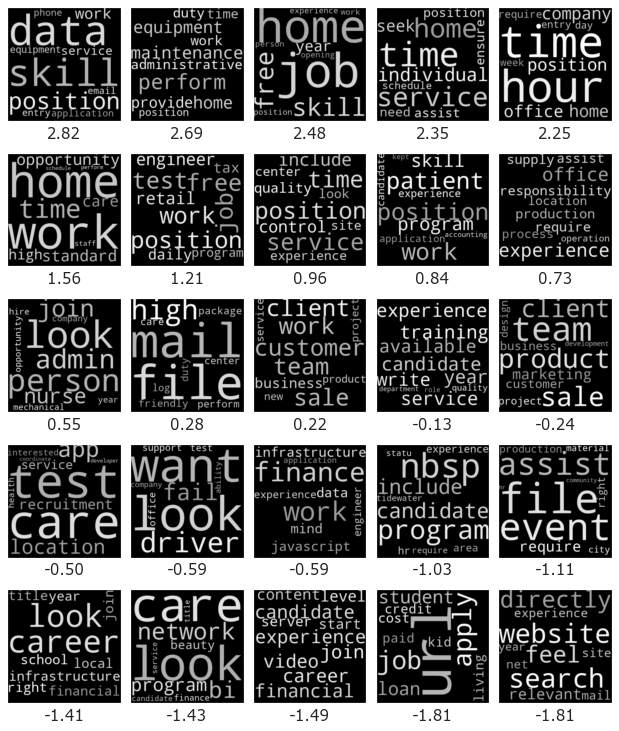

In [79]:
###### Feature-based (xi = 1)
W = result_0[18].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [80]:
for i in range(23,33): 
    print(i, result_0[i].get('method'), result_0[i].get('xi'), result_0[i].get('F_score'))

23 SDL-conv-filt 0.01 0.09375
24 SDL-conv-filt 0.01 0.037037037037037035
25 SDL-conv-filt 0.1 0.09651076466221234
26 SDL-conv-filt 0.1 0.08263912029323559
27 SDL-conv-filt 1 0.09914712153518124
28 SDL-conv-filt 1 0.13920454545454544
29 SDL-conv-filt 5 0.13333333333333333
30 SDL-conv-filt 5 0.1401673640167364
31 SDL-conv-filt 10 0.1517857142857143
32 SDL-conv-filt 10 0.19775739041794088


!! Y formulate reasonable consultative conference junior attract align east talent yeast
!! Y absolutely artist accomplish ranked shift optimal volume fixture communicate het
!! Y specialise inputting cooking festival follow assemble experiment print entire responsible
!! Y meeting trial subject service principle huge shoot nice virtual distribute
!! Y strength aw movie understand successfully mind sustain tx journalist independent
!! Y decision caller assume metric treat curriculum scalable sufficient penetration ad
!! Y nursing analytical complete transparency close massive bean initially listen funding
!! Y sell drop fail currently resume able invision appropriately developmental arrangement
!! Y annual inside acquisition washington array reporting troubleshoot home serve remote
!! Y website richard hear physician colleague ecommerce influence final north succes
!! Y assist scheme situation currency win sla environment underwriting hat suggest
!! Y offering intercom balance sw insid

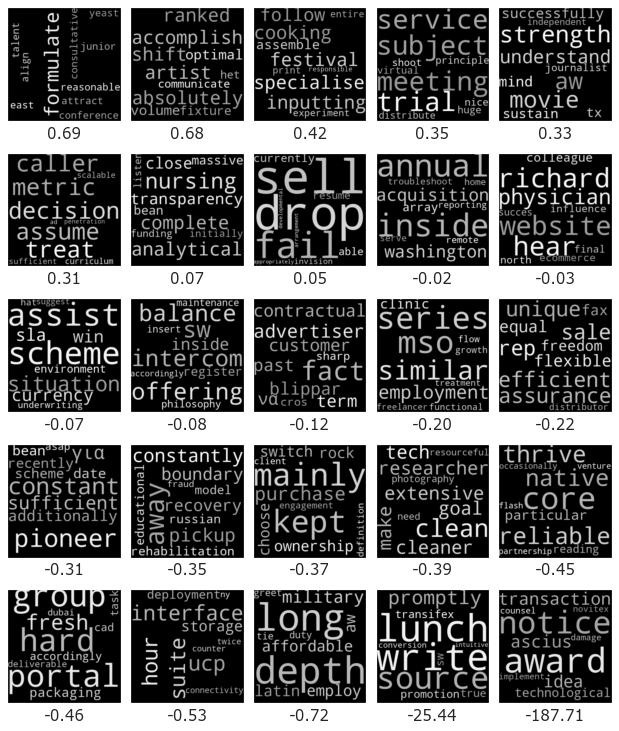

In [82]:
###### Convex - filter xi = 1

W = result_0[28].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

33 SDL-conv-feat (naive) 0.01 0.07246376811594203
34 SDL-conv-feat (naive) 0.01 nan
35 SDL-conv-feat (naive) 0.1 0.08285163776493257
36 SDL-conv-feat (naive) 0.1 nan
37 SDL-conv-feat (naive) 1 0.08314820691843859
38 SDL-conv-feat (naive) 1 0.08344113842173351
39 SDL-conv-feat (naive) 5 0.08390457910611461
40 SDL-conv-feat (naive) 5 0.08750357449242209
41 SDL-conv-feat (naive) 10 0.08283703302652949
42 SDL-conv-feat (naive) 10 0.0838585913949027
!! Y formulate reasonable consultative conference junior attract align east talent yeast
!! Y absolutely artist accomplish ranked shift optimal volume fixture communicate het
!! Y specialise inputting cooking festival follow assemble experiment print entire responsible
!! Y meeting trial subject service principle huge shoot nice virtual distribute
!! Y strength aw movie understand successfully mind sustain tx journalist independent
!! Y decision caller assume metric treat curriculum scalable sufficient penetration ad
!! Y nursing analytical comp

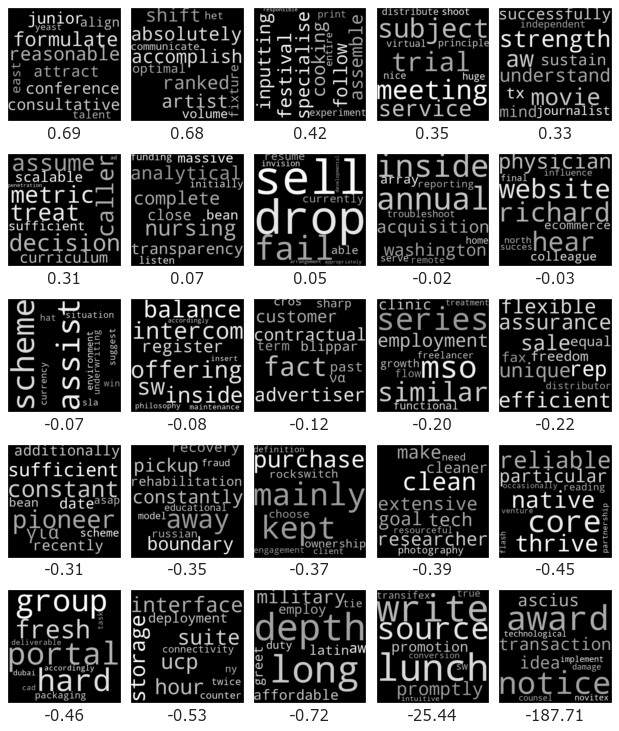

In [83]:
###### Convex - feature xi = 1
for i in range(33,43): 
    print(i, result_0[i].get('method'), result_0[i].get('xi'), result_0[i].get('F_score'))
    
W = result_0[28].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [85]:
pd.set_option('display.max_rows', None)
result = pd.DataFrame(data=[accuracy_0,sensitivity_0,specificity_0,f_score_0,reconstruct_0]).T
result = result.set_axis(['Accuracy', 'Sensitivity', 'Specificity', 'F_score', 'Reconstruct_Error'], axis=1, inplace=False)
result.insert(0, column='xi', value= xi_0)
result.insert(0, column='Method', value= method_0)
result = round(result.groupby(['Method', 'xi'], sort=False).agg(['mean','std']),3)
result

Accuracy        Sensitivity        Specificity  \
                                  mean    std        mean    std        mean   
Method                   xi                                                    
Logistic Regression (LR) ---     0.913    NaN       0.784    NaN       0.919   
NMF - LR                 ---     0.697  0.049       0.745  0.019       0.695   
SDL - Filter             0.01    0.907  0.025       0.739  0.009       0.915   
                         0.1     0.928  0.001       0.725  0.000       0.937   
                         1       0.907  0.003       0.732  0.009       0.915   
                         5       0.896  0.010       0.709  0.023       0.904   
                         10      0.898  0.009       0.686  0.000       0.907   
SDL - Feature            0.01    0.768  0.038       0.765  0.009       0.768   
                         0.1     0.755  0.081       0.748  0.051       0.756   
                         1       0.818  0.007       0.712  0.009       0.823   
                         5       0.744  0.017       0.752  0.000       0.744   
                         10      0.831  0.025       0.614  0.102       0.841   
SDL - Filter (Convex)    0.01    0.727  0.325       0.314  0.416       0.745   
                         0.1     0.445  0.304       0.618  0.273       0.437   
                         1       0.594  0.095       0.624  0.023       0.593   
                         5       0.738  0.046       0.484  0.065       0.749   
                         10      0.731  0.070       0.650  0.023       0.734   
SDL - Feature (Convex)   0.01    0.907  0.071       0.065  0.092       0.945   
                         0.1     0.579  0.534       0.422  0.596       0.586   
                         1       0.200  0.011       0.850  0.009       0.171   
                         5       0.087  0.030       1.000  0.000       0.046   
                         10      0.059  0.009       1.000  0.000       0.017   

                                     F_score        Reconstruct_Error         
                                 std    mean    std              mean    std  
Method                   xi                                                   
Logistic Regression (LR) ---     NaN   0.436    NaN             1.000    NaN  
NMF - LR                 ---   0.051   0.176  0.027             0.810  0.006  
SDL - Filter             0.01  0.025   0.411  0.068             0.978  0.017  
                         0.1   0.001   0.464  0.002             0.886  0.011  
                         1     0.003   0.402  0.004             0.811  0.007  
                         5     0.011   0.369  0.014             0.785  0.000  
                         10    0.009   0.365  0.019             0.790  0.002  
SDL - Feature            0.01  0.040   0.222  0.026             0.958  0.000  
                         0.1   0.087   0.214  0.045             0.961  0.001  
                         1     0.007   0.251  0.009             0.934  0.002  
                         5     0.017   0.201  0.010             0.911  0.002  
                         10    0.031   0.237  0.003             0.902  0.001  
SDL - Filter (Convex)    0.01  0.358   0.065  0.040             0.989  0.000  
                         0.1   0.329   0.090  0.010             0.989  0.000  
                         1     0.098   0.119  0.028             0.989  0.000  
                         5     0.051   0.137  0.005             0.887  0.000  
                         10    0.074   0.175  0.033             0.885  0.000  
SDL - Feature (Convex)   0.01  0.078   0.072    NaN             0.997  0.000  
                         0.1   0.585   0.083    NaN             0.997  0.000  
                         1     0.012   0.083  0.000             0.997  0.000  
                         5     0.031   0.086  0.003             0.979  0.001  
                         10    0.009   0.083  0.001             0.981  0.003

!! Y work look start skill time mso learn person want company
!! Y client home data work time caregiver day person entry team
!! Y team test work software product person grow customer new look
!! Y customer service support require provide equipment include duty quality maintain
!! Y project development technical test software application experience requirement management engineering
!! Y team work experience software look developer environment join want skill
!! Y management accounting operation process financial hr office business maintain ensure
!! Y new intern use base help program high look excellent online
!! Y company tidewater finance position opportunity work employee time benefit hour
!! Y career admin kept nvq permanent start school work old fantastic
!! Y beauty fragrance retail luxury consultant store recruiting make fashion want
!! Y test campaign real engineer hotel software company work product manager
!! Y fail week twice shall properly daily task experience data securi

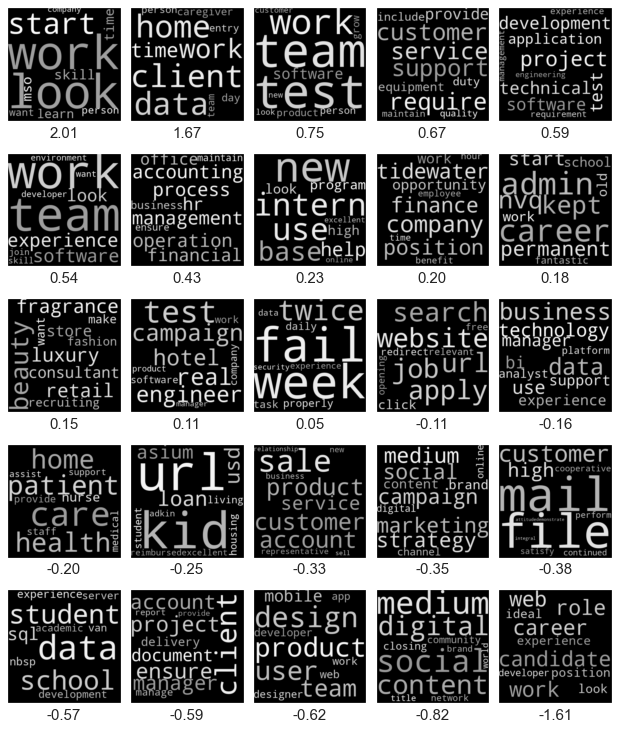

In [199]:
# NMF -> LR
W = result_0[1].get('W')
W2 = result_0[1].get('beta_regression')
W2 = np.asarray([list([1]) + list(W2[0])])
plot_topic_wordcloud([W,W2], total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [203]:
# Filter-based
W = result_0[6].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y transparent athen deliverable unload machinery proactive award strong sigma je
!! Y disrupt realize erp proud form individual global asset google salary
!! Y pull expect edit emotional editor hansi printer detailparticipate guest fl
!! Y car investment impactful coordinate scan technician en personally necessary satisfy
!! Y london minimize inventory machine competitive citizen let hospital scrum priority
!! Y start original hire recent total extract outstanding worker acros cook
!! Y ambassador engine volunteer knowledge young broader partnership bay shape powerful
!! Y texa cs airfare career paypal deadline bit road recruit mindset
!! Y director involve indian behavimy initiative landscape st llc say equipmentshipping
!! Y immediate fulfill respond argentum marital partner indicator heavy soon category
!! Y mso festival abc approve offline meet curriculum lean photography attorney
!! Y solution formal university cruise bug houston nj heavily boundary contractual
!! Y specificati

!! Y conversation believe vice category format hard soon chief innovator perfect
!! Y photography dealer variety german design inbound placement telecommunication consideration suit
!! Y user daily week accuracy measure set disaster actionable fellow natural
!! Y indium του exchange standard manual date treatment outgo woman competitor
!! Y really upgrade developer concise climate flexibility stellar accountability angel public
!! Y st image version starter discussion conduct gt currency journey related
!! Y validate usability anticipate accounting twice similar fortune energetic officer onboarding
!! Y premier complete lead ipad step participant prototyping mobility calculation expansion
!! Y application transformation method teamwork firm unique apex pioneer indirect update
!! Y spent movement startup possible healthy prioritize visibility collateral use athen
!! Y park retailer ethical additionally cleaner authentic amazon raw reward package
!! Y advertiser retention quote able comp

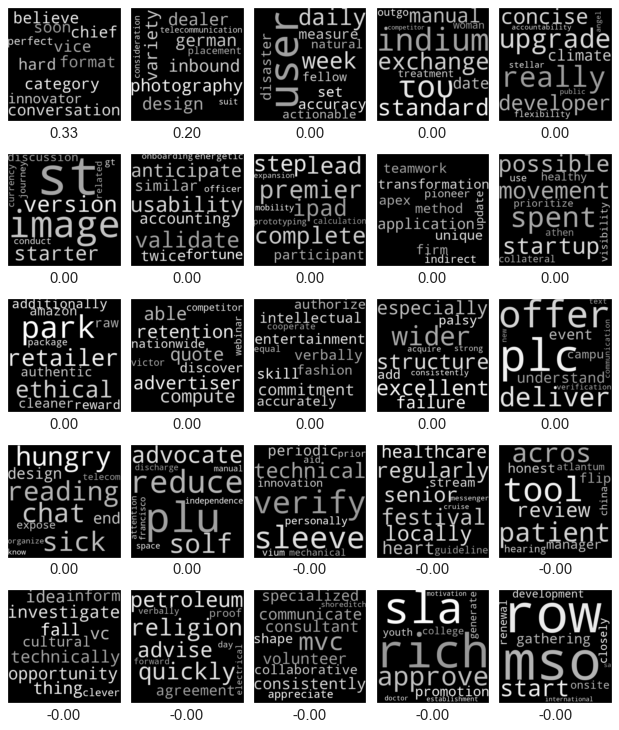

In [202]:
# Feature-based
W = result_0[18].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [193]:
# Convex-Filter-based
W = result_0[40].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y earn money entry engineering administrative gas oil skill time link
!! Y office administrative support assistant event manager meeting manage email assist
!! Y customer service support need provide problem question representative issue request
!! Y project management team manager manage work development budget technical scope
!! Y test qa quality automate automation case assurance plan requirement functional
!! Y financial accounting account finance report include bank prepare monthly reconciliation
!! Y experience require title skill year ability knowledge closing candidate strong
!! Y fail week shall twice properly daily task video complete limited
!! Y care home patient caregiver health nurse personal medical provide person
!! Y product engineering market feature new team manager define launch development
!! Y tidewater position finance statu resume employment dealer salary disability collection
!! Y service employee provide closing professional network solution value hr traini

In [212]:
# Convex-Feature-based

#W = result_0[28].get('loading')
#plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
result_0[28]

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 25,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.99713645e-05, 0.00000000e+00, 0.00000000e+00],
         [5.60276650e-04, 5.67738105e-05, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.34446388e-03],
         [1.09088246e-02, 0.00000000e+00, 1.96319466e-03, ...,
          3.09970096e-03, 0.00000000e+00, 3.19436879e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.26297008e-07, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-6.49147453, -0.54384258,  0.01838749,  2.06831537, -1.77386246,
          -2.00198706, -1.41715918, -1.46732754,  0.

In [209]:
for i in range(len(result_0)):
    print(i, result_0[i].get('method'), result_0[i].get('xi'))

0 LR None
1 MF-LR None
2 MF-LR None
3 SDL-conv-filt 0.01
4 SDL-conv-filt 0.01
5 SDL-conv-filt 0.1
6 SDL-conv-filt 0.1
7 SDL-conv-filt 1
8 SDL-conv-filt 1
9 SDL-conv-filt 5
10 SDL-conv-filt 5
11 SDL-conv-filt 10
12 SDL-conv-filt 10
13 SDL-conv-feat (naive) 0.01
14 SDL-conv-feat (naive) 0.01
15 SDL-conv-feat (naive) 0.1
16 SDL-conv-feat (naive) 0.1
17 SDL-conv-feat (naive) 1
18 SDL-conv-feat (naive) 1
19 SDL-conv-feat (naive) 5
20 SDL-conv-feat (naive) 5
21 SDL-conv-feat (naive) 10
22 SDL-conv-feat (naive) 10
23 SDL-feat (naive) 0.01
24 SDL-feat (naive) 0.01
25 SDL-feat (naive) 0.1
26 SDL-feat (naive) 0.1
27 SDL-feat (naive) 1
28 SDL-feat (naive) 1
29 SDL-feat (naive) 5
30 SDL-feat (naive) 5
31 SDL-feat (naive) 10
32 SDL-feat (naive) 10
33 SDL-filt 0.01
34 SDL-filt 0.01
35 SDL-filt 0.1
36 SDL-filt 0.1
37 SDL-filt 1
38 SDL-filt 1
39 SDL-filt 5
40 SDL-filt 5
41 SDL-filt 10
42 SDL-filt 10
